In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astroML.datasets import generate_mu_z
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from astropy import cosmology
from astropy.cosmology import LambdaCDM
from scipy.stats import norm
import emcee
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

z = np.linspace(0.01, 2, 100)

***Gaussian Process Regression***

In [11]:
kernel =ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) #fitted by hand, not very difficult

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2) #alpha is the variance of additional Gaussian measurement noise on the training observations
gp.fit(z_sample[:,np.newaxis], mu_sample)
mu_fit,  sigma_fit= gp.predict(z[:,np.newaxis], return_std=True)

(35.0, 50.0)

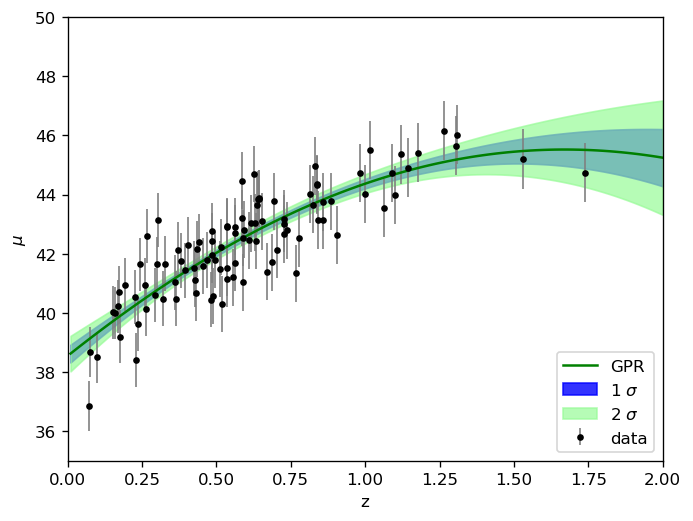

In [12]:
plt.figure(dpi=120)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_fit, '-g',label='GPR')
plt.fill_between(z, mu_fit - sigma_fit, mu_fit + sigma_fit, alpha=0.8, color='blue', label='1 $\sigma$')
plt.fill_between(z, mu_fit - 2 * sigma_fit, mu_fit + 2 * sigma_fit, alpha=0.7, color='palegreen', label='2 $\sigma$')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

It's not that bad! \
Now I apply some cosmology, and, instead of solving the integral, I will use astropy.cosmology

(35.0, 50.0)

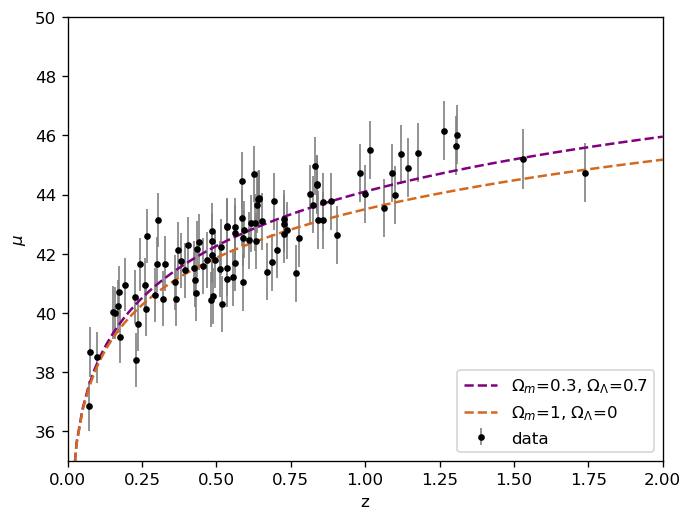

In [13]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
mu_true = cosmo.distmod(z) 
cosmo1 = LambdaCDM(H0=70, Om0=1, Ode0=0)
mu_true1 = cosmo1.distmod(z)
plt.figure(dpi=120)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, '--', c='purple',label='$\Omega_m$=0.3, $\Omega_\Lambda$=0.7')
plt.plot(z, mu_true1, '--', c='chocolate',label='$\Omega_m$=1, $\Omega_\Lambda$=0') 
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

Just looking at this fit I see that the model without Dark Energy is not that bad... But now let's try some Bayesian statistic. \
***MCMC***

In [14]:
#function for the distance mu_true
def distance_model(z, H0, Om):
    cosmo_m = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om) #Ode0 is omega_lambda
    return cosmo_m.distmod(z).value

#What are the measured value of H0 and OmegaM. Are they correlated?  
#MCMC 
#1) Loglikelihood
def log_likelihood(theta):
    Om, H0 = theta
    if Om<0:
        return -np.inf
    else:
        mu_model = distance_model(z_sample, H0, Om)
    return np.sum(norm.logpdf(mu_sample, loc=mu_model, scale=dmu))

#2) Priors
def log_prior(theta):
    Om, H0 = theta
    if 50 < H0 < 100 and 0.01 < Om < 1:
        # Gaussian prior for H0 with mean 70 and std 5
        lp_H0 = norm.logpdf(H0, loc=70, scale=5)
        # Gaussian prior for Om with mean 0.3 and std 0.1
        lp_Om = norm.logpdf(Om, loc=0.3, scale=0.1)
        return lp_H0 + lp_Om
    else:
        return -np.inf #If the parameters fall outside the specified bounds, the prior should assign a prob of 0 to these parameter values. In log space= -inf

#3) Posteriors   
def log_posterior(theta):
    Om, H0 = theta  
    lp = log_prior(theta)
    ll = log_likelihood(theta)
    return lp + ll


In [15]:
ndim = 2  
nwalkers = 10  
nsteps = 10000  

initial_guesses = np.array([0.2,80]) + 1e-2 * np.random.randn(nwalkers, ndim) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_guesses, nsteps, progress=True)
samples = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:39<00:00, 62.85it/s]


[32.39269983 35.12100083]


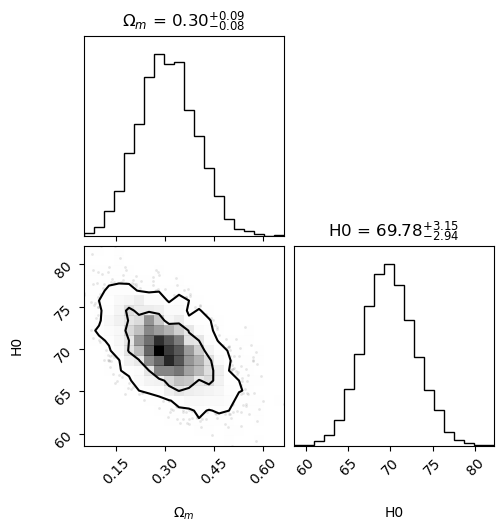

In [16]:
samples_2d = sampler.get_chain(discard=3000, thin=15, flat=True) # discard: 30% of the samples; thinning interval: about half of tau (around 32)
fig = corner.corner(
    samples_2d, labels=['$\Omega_m$', 'H0'], levels=[0.68,0.95], show_titles=True
)

(35.0, 50.0)

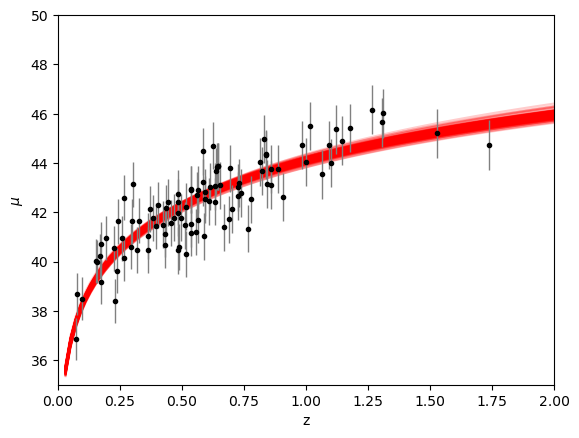

In [17]:
for Om,H0, in samples_2d[np.random.choice(len(samples_2d), size=200)]:
    plt.plot(z[1:], distance_model(z[1:], H0, Om), c='red', alpha=0.2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

1814it [00:06, 260.82it/s, +1000 | bound: 0 | nc: 1 | ncall: 7146 | eff(%): 45.786 | loglstar:   -inf < -132.813 <    inf | logz: -134.301 +/-    nan | dlogz:  0.001 >  1.009]


68% parameter credible regions are:
 [[0.3154020514337742, 0.6556584643966514], [61.745194519525505, 70.25233633155081]]

Mean and covariance of parameters are: [ 0.48405084 65.97202343]
[[ 0.02864461 -0.54156194]
 [-0.54156194 17.90130602]]


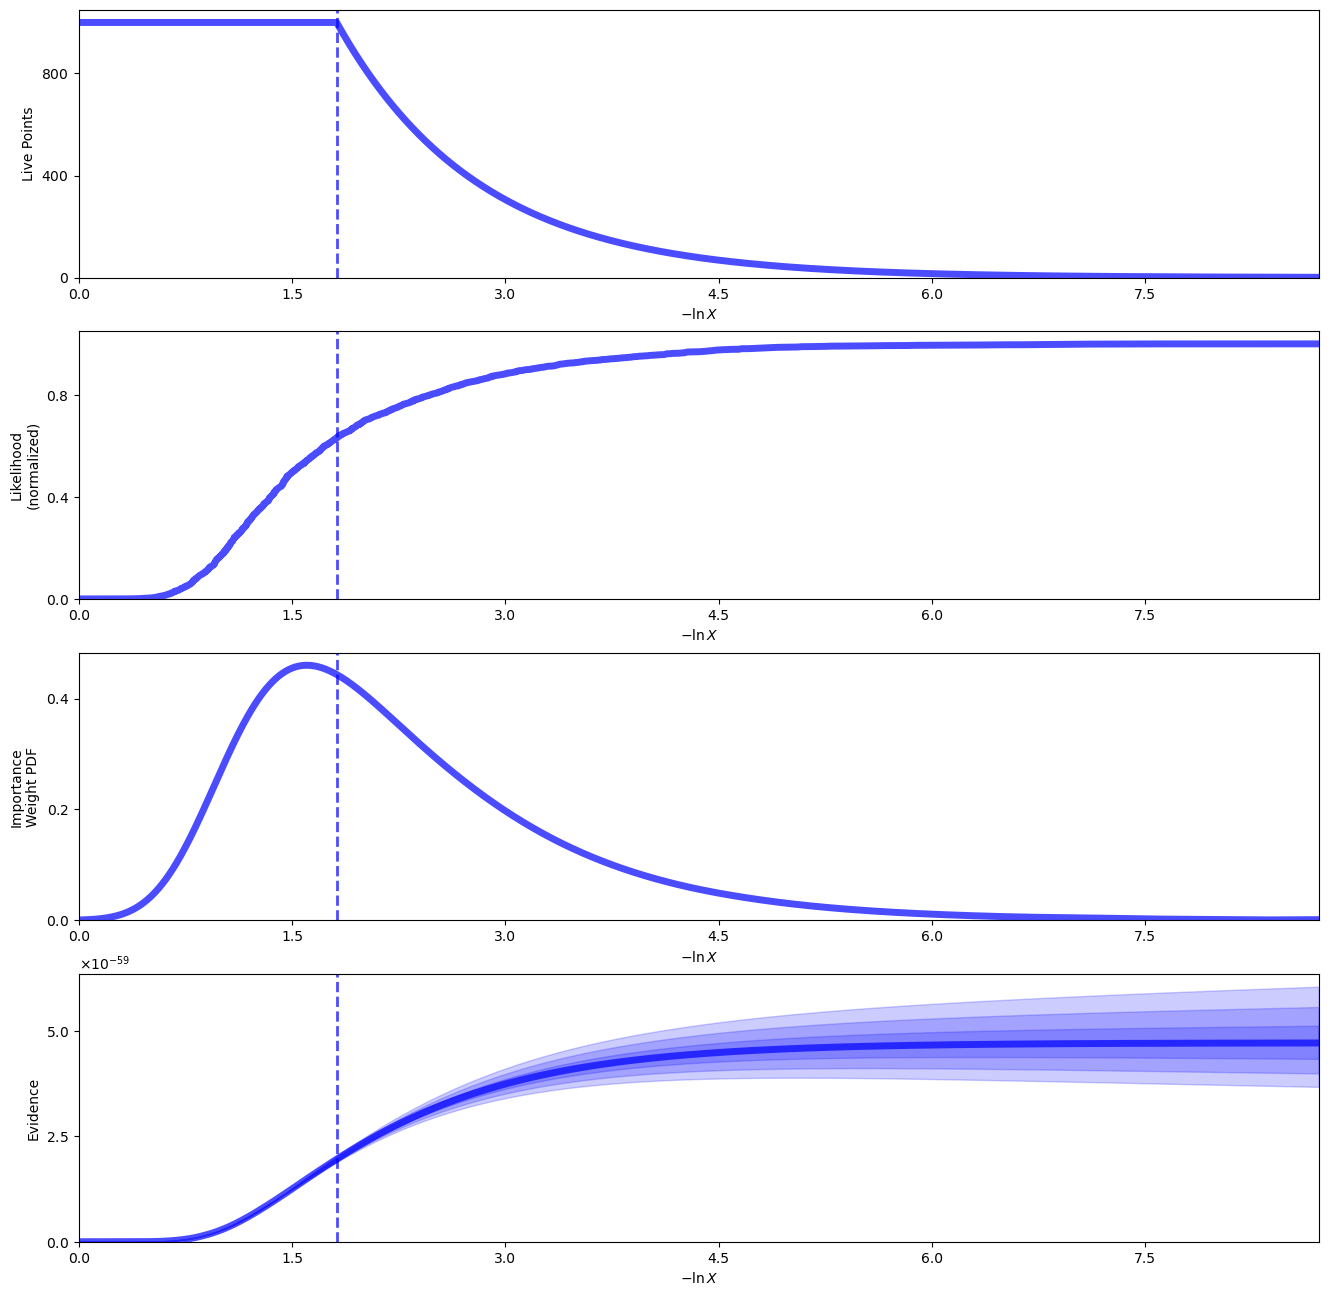

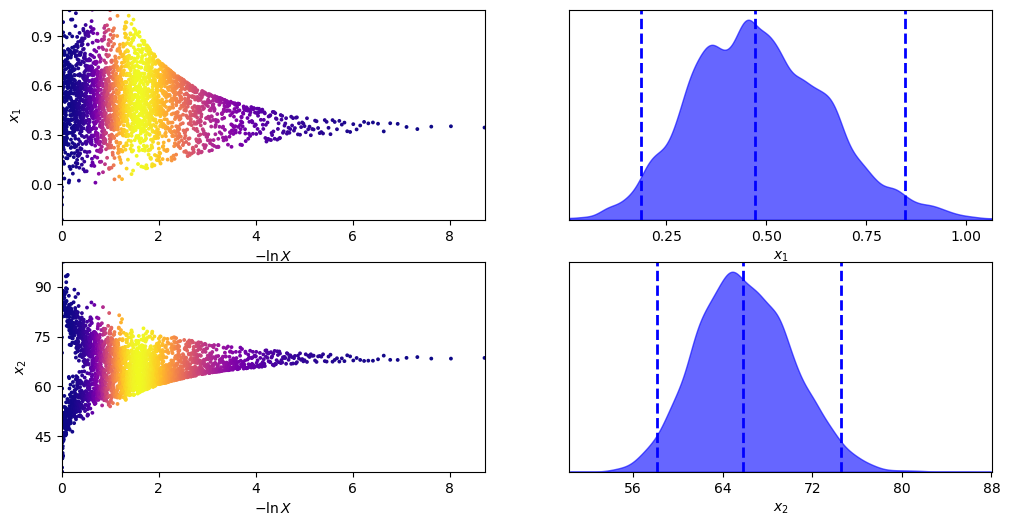

In [18]:
#Let's see what happens with nested sampling: using a Gaussian prior now I use its CDF
def ptform(u):
    uH0, uOm = u
    mu = np.array([0.5, 65])  # Mean values of the normal priors
    sigma = np.array([0.2, 10])  # Standard deviations of the normal priors
    return norm.ppf(u, loc=mu, scale=sigma)  # Inverse CDF transformation


# "Static" nested sampling.
sampler2 = dynesty.NestedSampler(log_likelihood, ptform, ndim,nlive=1000)
sampler2.run_nested()
sresults = sampler2.results
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights



# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

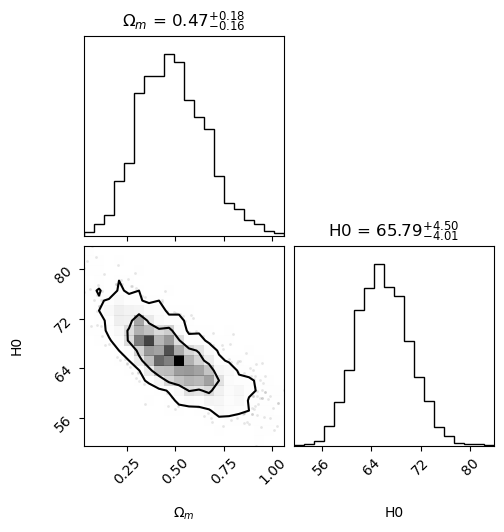

In [19]:
# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults) #doesn't work
samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(
    samples_equal, labels=['$\Omega_m$', 'H0'], levels=[0.68,0.95], show_titles=True
)

(35.0, 50.0)

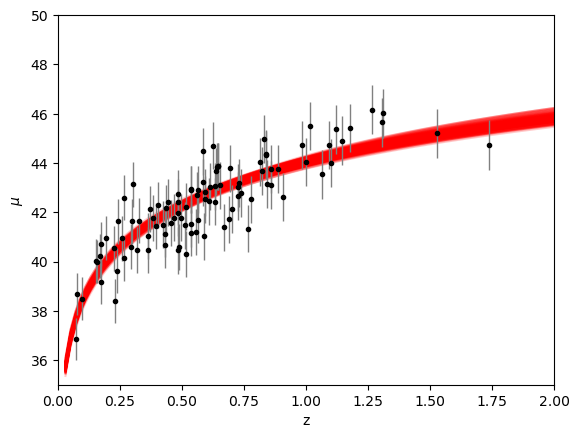

In [20]:
for Om,H0, in samples_equal[np.random.choice(len(samples_equal), size=200)]:
    plt.plot(z[1:], distance_model(z[1:], H0, Om), c='red', alpha=0.2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

***Bayesian analysis with no Dark Energy***

1998it [00:08, 244.66it/s, +1000 | bound: 0 | nc: 1 | ncall: 8707 | eff(%): 38.900 | loglstar:   -inf < -133.530 <    inf | logz: -135.147 +/-    nan | dlogz:  0.001 >  1.009]


(35.0, 50.0)

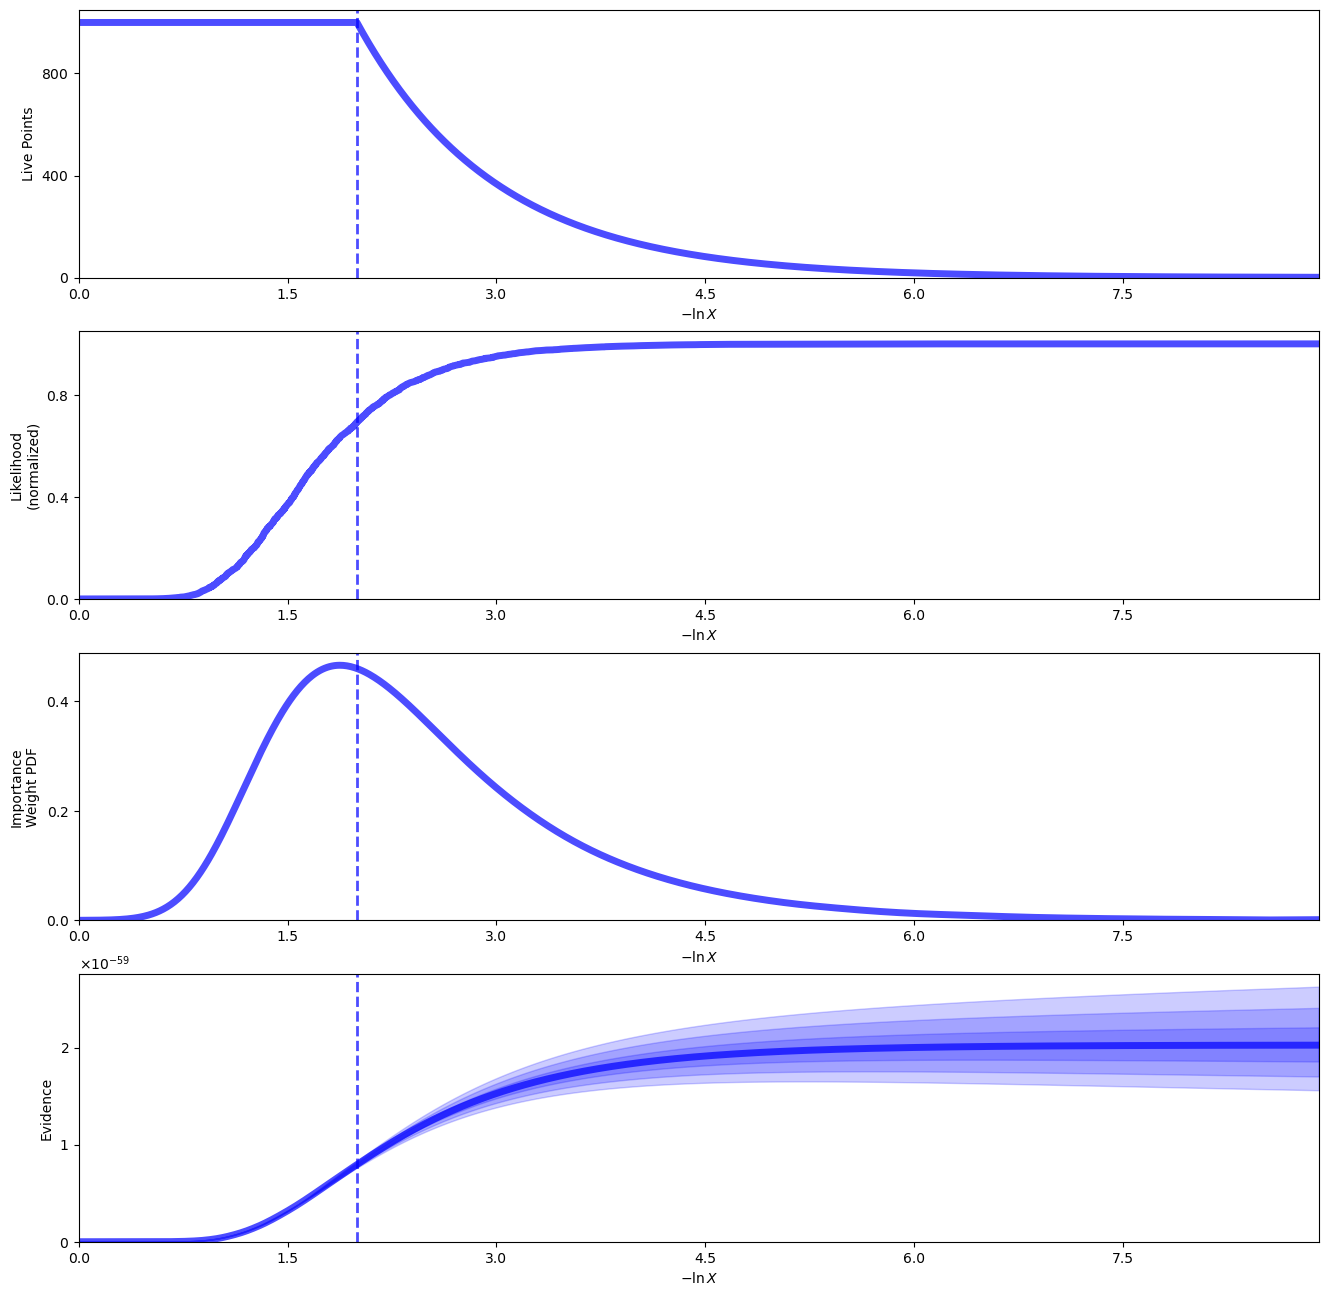

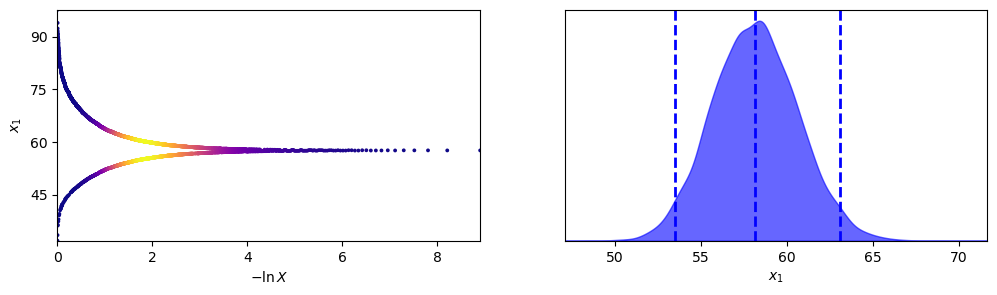

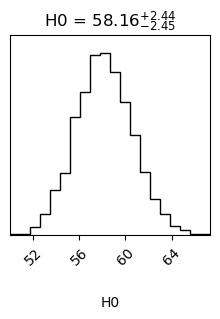

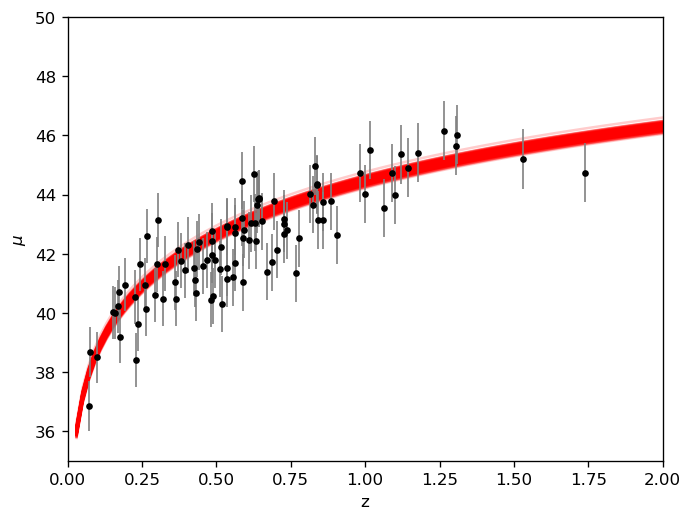

In [21]:
#I was forgetting about testing of Dark Energy here
def log_likelihood_noDE(theta):
    H0 = float(theta)
    Om=1
    mu_model = distance_model(z_sample, H0, Om)
    return np.sum(norm.logpdf(mu_sample, loc=mu_model, scale=dmu))
def ptform_noDE(u):
    uH0 = u
    mu = np.array(65)  # Mean values of the normal priors
    sigma = np.array(10)  # Standard deviations of the normal priors
    return norm.ppf(u, loc=mu, scale=sigma)  # Inverse CDF transformation
ndim=1
sampler2 = dynesty.NestedSampler(log_likelihood_noDE, ptform_noDE, ndim,nlive=1000)
sampler2.run_nested()
sresults = sampler2.results
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


samples_equal = dyfunc.resample_equal(samples, weights)
fig = corner.corner(
    samples_equal, labels=['H0'], levels=[0.68,0.95], show_titles=True
)
plt.figure(dpi=120)
for H0, in samples_equal[np.random.choice(len(samples_equal), size=200)]:
    plt.plot(z[1:], distance_model(z[1:], H0, Om), c='red', alpha=0.2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

It seems that the DE is not that necessary... There's a sort of degeneracy about the composition of the Universe...

***Increasing of 10 times the measurement that I have***

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(35.0, 50.0)

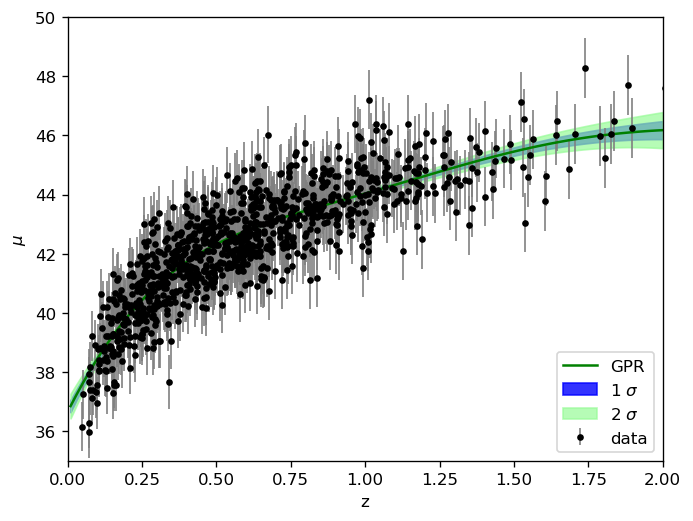

In [23]:
z_sample_large, mu_sample_large, dmu_large = generate_mu_z(1000, random_state=1234)  # 10 times the original 100 data points
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu_large**2)
gp.fit(z_sample_large[:, np.newaxis], mu_sample_large)
mu_fit_large, sigma_fit_large = gp.predict(z[:, np.newaxis], return_std=True)

plt.figure(dpi=120)
plt.errorbar(z_sample_large, mu_sample_large, dmu_large, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(z, mu_fit_large, '-g', label='GPR')
plt.fill_between(z, mu_fit_large - sigma_fit_large, mu_fit_large + sigma_fit_large, alpha=0.8, color='blue', label='1 $\sigma$')
plt.fill_between(z, mu_fit_large - 2 * sigma_fit_large, mu_fit_large + 2 * sigma_fit_large, alpha=0.7, color='palegreen', label='2 $\sigma$')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)

In [24]:
def log_likelihood(theta):
    Om, H0 = theta
    if Om < 0:
        return -np.inf
    else:
        mu_model = distance_model(z_sample_large, H0, Om)
    return np.sum(norm.logpdf(mu_sample_large, loc=mu_model, scale=dmu_large))

4147it [02:21, 29.31it/s, +1000 | bound: 1 | nc: 1 | ncall: 37816 | eff(%): 13.980 | loglstar:   -inf < -1360.668 <    inf | logz: -1364.601 +/-    nan | dlogz:  0.001 >  1.009]
C:\Users\Asus\anaconda3\lib\site-packages\dynesty\plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


68% parameter credible regions are:
 [[0.25346579157932564, 0.4101242267589521], [66.9929429971551, 71.15653451034883]]

Mean and covariance of parameters are: [ 0.3309111  69.08368323]
[[ 0.00616371 -0.1483201 ]
 [-0.1483201   4.50584455]]


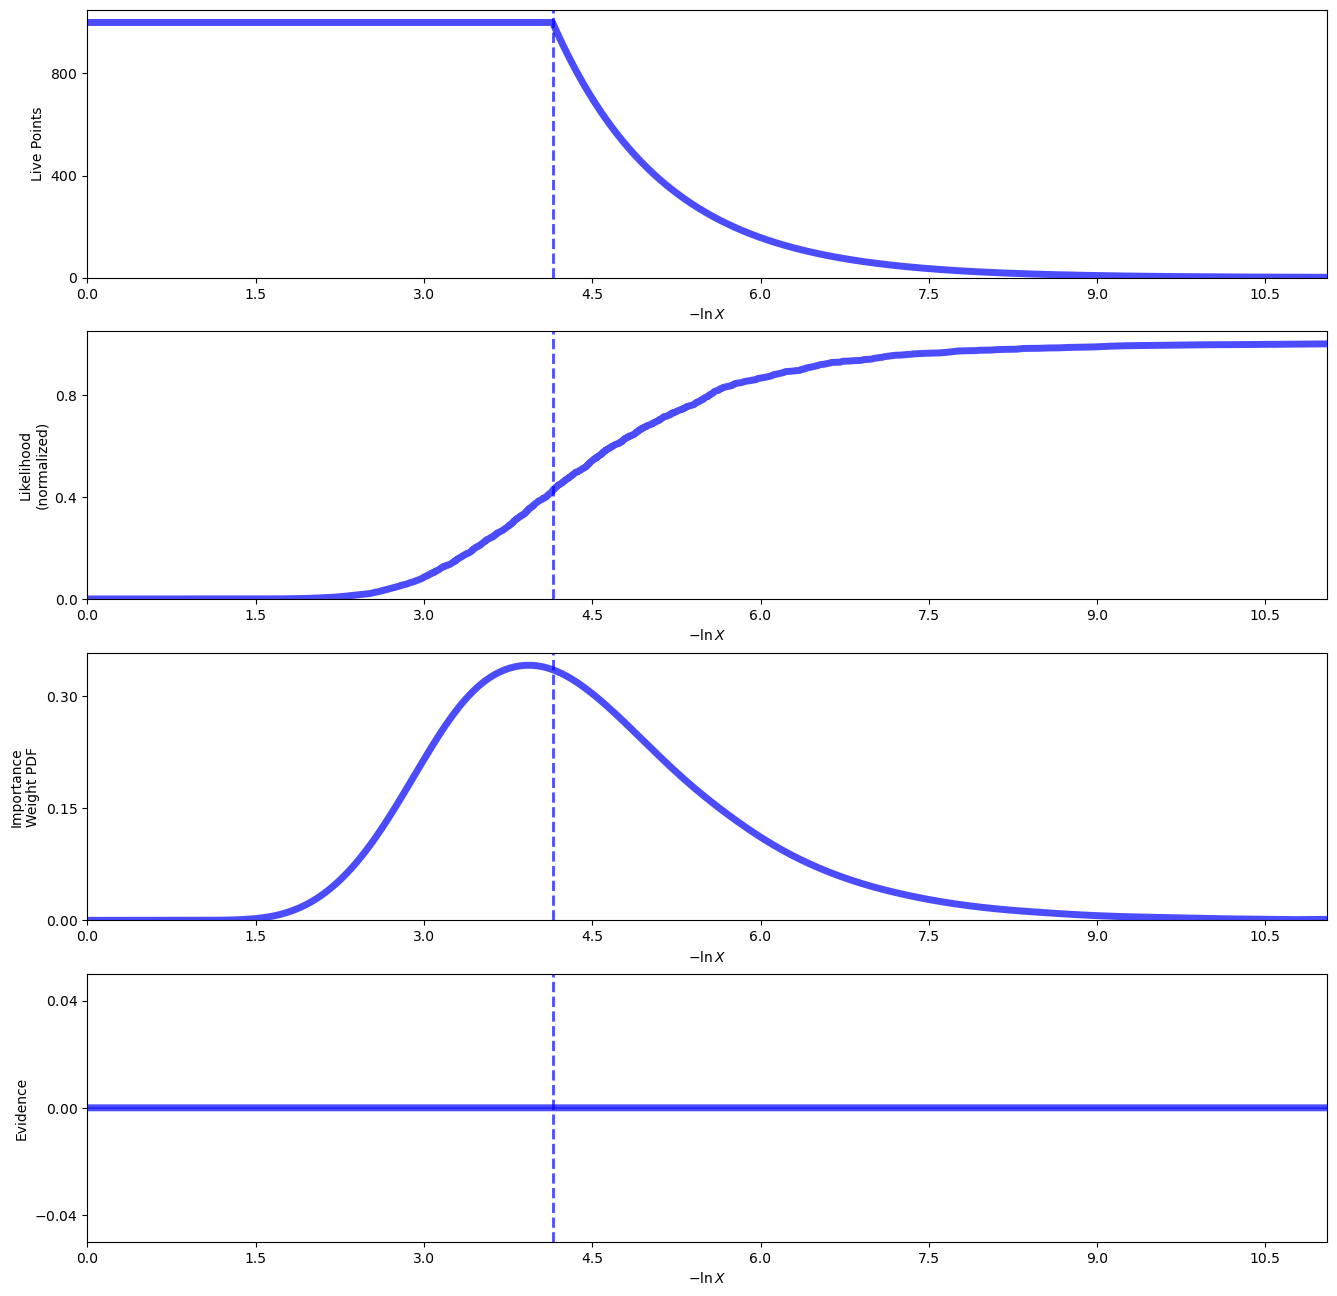

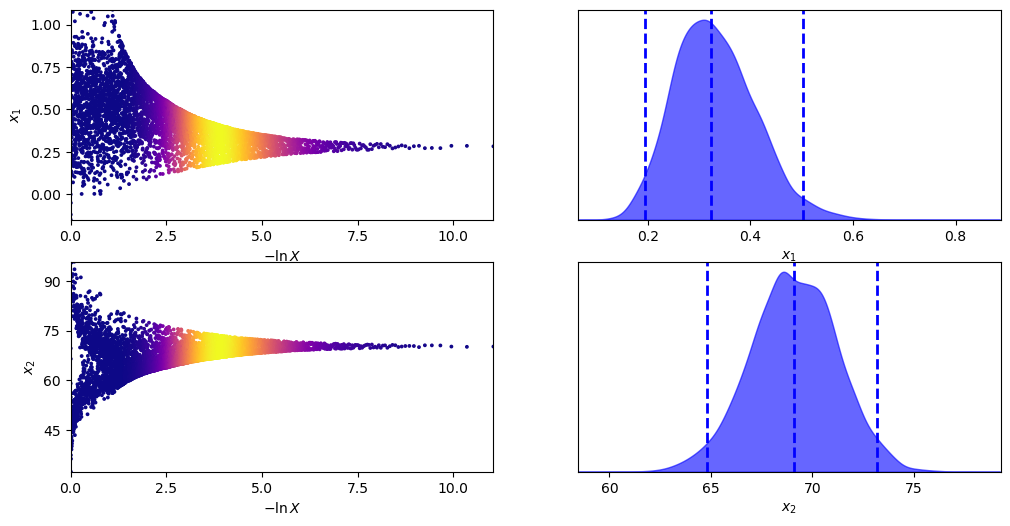

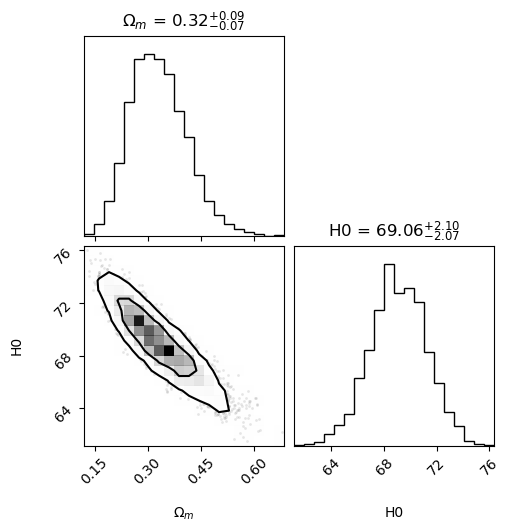

In [25]:
# Running Nested Sampling
ndim = 2
sampler2_large = dynesty.NestedSampler(log_likelihood, ptform, ndim, nlive=1000)
sampler2_large.run_nested()
sresults_large = sampler2_large.results

# Plotting results
rfig, raxes = dyplot.runplot(sresults_large)
tfig, taxes = dyplot.traceplot(sresults_large)

samples_large = sresults_large.samples
weights_large = np.exp(sresults_large.logwt - sresults_large.logz[-1])

quantiles_large = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_large) for samps in samples_large.T]
print('68% parameter credible regions are:\n ' + str(quantiles_large) + '\n')

mean_large, cov_large = dyfunc.mean_and_cov(samples_large, weights_large)
print('Mean and covariance of parameters are: ' + str(mean_large) + '\n' + str(cov_large))

samples_equal_large = dyfunc.resample_equal(samples_large, weights_large)
fig = corner.corner(samples_equal_large, labels=['$\Omega_m$', 'H0'], levels=[0.68, 0.95], show_titles=True)

(35.0, 50.0)

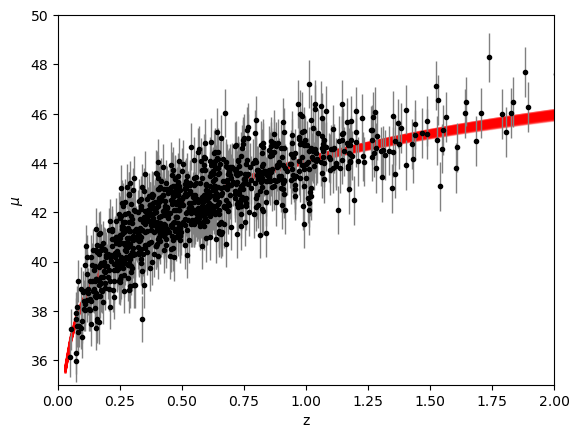

In [26]:
for Om, H0 in samples_equal_large[np.random.choice(len(samples_equal_large), size=200)]:
    plt.plot(z[1:], distance_model(z[1:], H0, Om), c='red', alpha=0.2)

plt.errorbar(z_sample_large, mu_sample_large, dmu_large, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(35, 50)